In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from IPython.display import Image

import pickle
from numpyro.infer import MCMC

In [3]:
import json
with open('./geojson-counties-fips.json','rb') as f:
    counties = json.load(f)

import plotly.express as px

# define date range for plots

In [4]:
df = pd.read_parquet('mcmc_res_data_df.parquet').sort_values(by=['date','FIPS'])
dates_min = df['date'].min()
dates_max = df['date'].max()
dates_to_plot = pd.Series(pd.read_parquet('time_series_df.parquet')['date'].unique())
dates_to_plot = dates_to_plot[dates_to_plot>=dates_min]
dates_to_plot = dates_to_plot[dates_to_plot<=dates_max]
dates_to_plot = dates_to_plot.reset_index(drop=True)
dates_to_plot


0     2021-02-06
1     2021-02-07
2     2021-02-08
3     2021-02-09
4     2021-02-10
         ...    
180   2021-08-05
181   2021-08-06
182   2021-08-07
183   2021-08-08
184   2021-08-09
Length: 185, dtype: datetime64[ns]

# choropleth of antivax tweet rates

In [5]:
df = pd.read_parquet('time_series_df.parquet').sort_values(by=['date','FIPS'])
df = df[df['date'].isin(dates_to_plot)]
df = df[['FIPS','date','cumulative_antivax_tweets','population']].groupby('FIPS').agg('last').reset_index()
df['cumulative_antivax_tweets_per_capita_per_day'] = (df['cumulative_antivax_tweets'])/(df['population']*df['date'].nunique())
df['cumulative_antivax_tweets_per_capita_per_day_log'] = np.log10(df['cumulative_antivax_tweets_per_capita_per_day'])
df = df.rename(columns={'FIPS':'fips'})
df['fips'] = df['fips'].apply(lambda x: str(x) if len(str(x))==5 else '0'+str(x))



/opt/miniconda3/envs/antivax_tweets/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


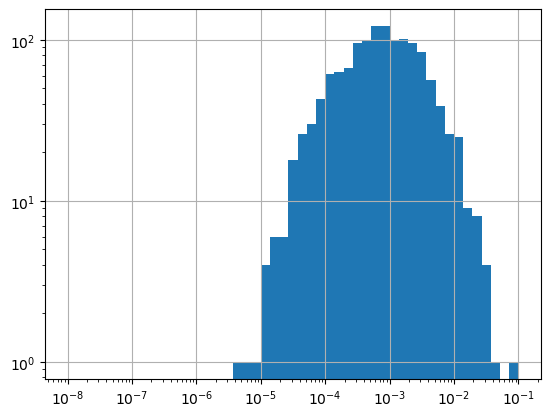

In [6]:
#distribution of anitvax tweet counts is approx lognormal
df['cumulative_antivax_tweets_per_capita_per_day'].hist(bins=np.logspace(-8,-1,50))
plt.xscale('log')
plt.yscale('log')
plt.show()

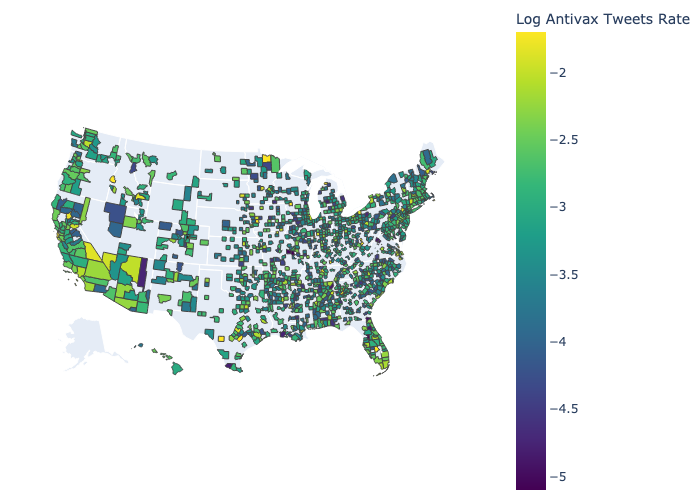

In [7]:
fig = px.choropleth(df, geojson=counties, locations='fips', color='cumulative_antivax_tweets_per_capita_per_day_log',
                           color_continuous_scale="Viridis",
                           range_color=(-5.1, -1.7),
                           scope="usa",
                           labels={'cumulative_antivax_tweets_per_capita_per_day_log':'Log Antivax Tweets Rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
Image(fig.to_image(format="png"))
# fig.show()

# choropleth of antivax exposures

In [8]:
def get_retweet_neighbor_edgelist(df, raw_edgelist_path = 'raw_retweet_neighbor_edgelist.parquet',
                                  normalize=True, time_bin_length=8):
    counties = df['FIPS'].unique()
    edgelist = pd.read_parquet(raw_edgelist_path)
    edgelist = edgelist.rename(columns = {'retweeting_FIPS':'county1', 'retweeted_FIPS':'county2'})
    edgelist = edgelist[edgelist['county1'].isin(counties)] #drop unneeded counties
    edgelist = edgelist[edgelist['county2'].isin(counties)] #drop unneeded counties
    edgelist['weight'] = edgelist['n_retweets_per_day']
    if normalize:
        norm = edgelist.groupby(by=['county1']).agg({'weight':'sum'}).reset_index().rename(columns = {'weight':'norm'}) #get normalizaiton factor
        edgelist = edgelist.merge(norm, on=['county1'],how='left') 
        edgelist['weight'] = edgelist['weight']/edgelist['norm'] #normalize each county's neighbor weights
    edgelist = edgelist.sort_values('county1')[['county1','county2','weight']].reset_index(drop=True) #make pretty
    return edgelist

def get_neighbor_mean(df, cols, neighbor_type = 'geo', pop_weighting=False, normalize_edgelist=True):
    
    if isinstance(neighbor_type,pd.DataFrame): #manually override edgelist for testing.
        edgelist = neighbor_type
        neighbor_type = ''
    elif neighbor_type == 'geo':
        edgelist = get_geo_neighbor_edgelist(df, spatial_regrssion_power=-1, max_neighbor_distance=200,
                                             normalize = normalize_edgelist)
    elif neighbor_type == 'retweet':
        edgelist = get_retweet_neighbor_edgelist(df, normalize = normalize_edgelist)
        
    if pop_weighting:
        pops = df[['FIPS','population']].drop_duplicates().reset_index(drop=True)
        edgelist = edgelist.merge(pops.rename(columns={'FIPS':'county1','population':'pop1'}), on='county1', how='inner')
        edgelist = edgelist.merge(pops.rename(columns={'FIPS':'county2','population':'pop2'}), on='county2', how='inner')
        edgelist['weight'] = edgelist['weight']*(edgelist['pop2']/edgelist['pop1'])
        norm = edgelist.groupby(by=['county1']).agg({'weight':'sum'}).reset_index().rename(columns = {'weight':'norm'}) #get normalizaiton factor
        edgelist = edgelist.merge(norm, on=['county1'],how='left') 
        edgelist['weight'] = edgelist['weight']/edgelist['norm'] #normalize each county's neighbor weights
        edgelist = edgelist.drop(columns=['pop1','pop2','norm'])

    for col in cols:
        means_df_list = list()
        for date in df['date'].unique():
            a = (df[df['date']==date][['FIPS',col]]).rename(columns={'FIPS':'county2'})
            means_df = edgelist.copy().merge(a, on='county2', how='left')
            means_df['weight*col'] = means_df['weight']*means_df[col]
            means_df = means_df.groupby('county1').agg({'weight*col':'sum'}).rename(columns = {'weight*col':(col+'_'+neighbor_type+'_neighbor_mean')})
            means_df['date'] = date
            means_df_list.append(means_df)
        means_df = pd.concat(means_df_list).reset_index().rename(columns = {'county1':'FIPS'})
        df = df.merge(means_df, on=['FIPS','date'], how='left')   
    return df

def get_exposure(df, cols, neighbor_type): #positive. 1.2
    df=df.copy()
    df1 = df[['FIPS','date','population']+cols].copy()
    for col in cols:
        df1[col+'xpop'] = df[col]*df['population']
        df1 = get_neighbor_mean(df1,[col+'xpop'], 
                                neighbor_type=neighbor_type, 
                                pop_weighting=(True if neighbor_type=='geo' else False),
                                normalize_edgelist=False)
#         df[col+'_exposure'] = df1.eval(col+'xpop_'+neighbor_type+'_neighbor_mean')
        df[col+'_exposure'] = df1.eval(col+'xpop_'+neighbor_type+'_neighbor_mean/population')
    return df



In [9]:
df = pd.read_parquet('time_series_df.parquet').sort_values(by=['date','FIPS'])
df = df[df['date'].isin(dates_to_plot)]
df = df[['FIPS','date','cumulative_antivax_tweets','population']].groupby('FIPS').agg('last').reset_index()
df['cumulative_antivax_tweets_per_capita_per_day'] = df['cumulative_antivax_tweets']/(df['population']*df['date'].nunique())
df = get_exposure(df, ['cumulative_antivax_tweets_per_capita_per_day'], 'retweet').rename(columns={'FIPS':'fips'})

df['cumulative_antivax_tweets_per_capita_per_day_exposure_log'] = np.log10(df['cumulative_antivax_tweets_per_capita_per_day_exposure'])

df['fips'] = df['fips'].apply(lambda x: str(x) if len(str(x))==5 else '0'+str(x))



/opt/miniconda3/envs/antivax_tweets/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10



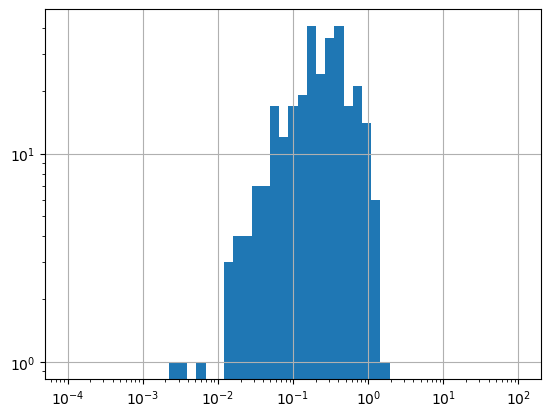

In [10]:
#distribution of exposures is approx lognormal
df['cumulative_antivax_tweets_per_capita_per_day_exposure_log'].hist(bins=np.logspace(-4,2,50))
plt.xscale('log')
plt.yscale('log')
plt.show()

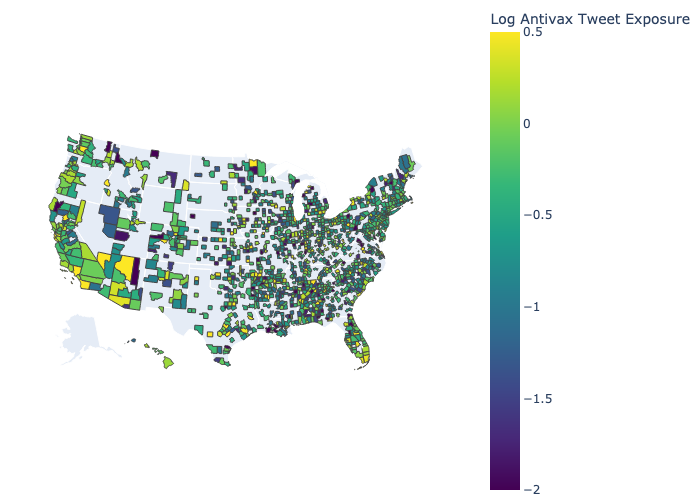

In [11]:
fig = px.choropleth(df, geojson=counties, locations='fips', color='cumulative_antivax_tweets_per_capita_per_day_exposure_log',
                           color_continuous_scale="Viridis",
                           range_color=(-2, 0.5),
                           scope="usa",
                           labels={'cumulative_antivax_tweets_per_capita_per_day_exposure_log':'Log Antivax Tweet Exposure'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
Image(fig.to_image(format="png"))
# fig.show()

# time series of antivax content production rate

In [12]:
def get_tlags(df, cols, lags = [1], drop=False, suffix=''): #lags in units of days
    lagged_dfs = list()
    for lag in lags:
        lag_col_renames = dict(zip(cols, [x+'_tlag'+str(lag)+suffix for x in cols]))
        df_lagged = df.copy()[['date','FIPS']+cols].rename(columns = lag_col_renames)
        df_lagged['date'] = df_lagged['date']+pd.DateOffset(days=lag)
        lagged_dfs.append(df_lagged)
    for lagged_df in lagged_dfs:
        df = df.merge(lagged_df, on=['date','FIPS'], how='inner')
    if drop: df = df.drop(columns = cols) 
    return df

def get_dxdts(df, cols, lags = [1], drop=False):  #lags in units of days
    df = get_tlags(df, cols, lags, drop=False, suffix='_temp')
    for lag in lags:
        temp_lag_cols = [col+'_tlag'+str(lag)+'_temp' for col in cols]
        for i,_ in enumerate(cols):
            df[cols[i]+'_dxdt'+str(lag)] = (df[cols[i]] - df[temp_lag_cols[i]])/lag
    all_temp_lag_cols = [col+'_tlag'+str(lag)+'_temp' for col in cols for lag in lags]
    df = df.drop(columns = all_temp_lag_cols)
    if drop: df = df.drop(columns = cols)
    return df

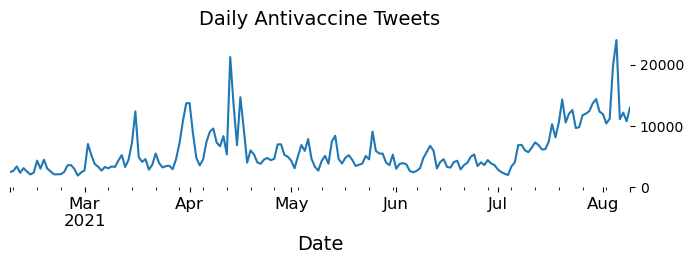

In [13]:
#antivax tweets per day

fig, ax = plt.subplots(figsize=(8, 2))

df = pd.read_parquet('time_series_df.parquet').sort_values(by=['date','FIPS'])
df = df[df['date'].isin(dates_to_plot)]
df = get_dxdts(df, ['cumulative_antivax_tweets'])
df = df[['FIPS','date','cumulative_antivax_tweets_dxdt1']].groupby('date').agg({'cumulative_antivax_tweets_dxdt1':'sum'})
df.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().set_ticks([0, 10000, 20000])
ax.yaxis.tick_right()
ax.legend().set_visible(False)
# plt.legend(['Number of Antivax Tweets'], frameon=False, fontsize=14, loc='upper left')
plt.title('Daily Antivaccine Tweets',fontsize=14)
# plt.ylabel('Antivax Tweets', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=12)#, rotation=90)
plt.yticks(fontsize=10)#, rotation=90)


plt.show()



In [14]:
print(dates_to_plot.min())
print(dates_to_plot.max())

2021-02-06 00:00:00
2021-08-09 00:00:00


# time series of antivax sentiment

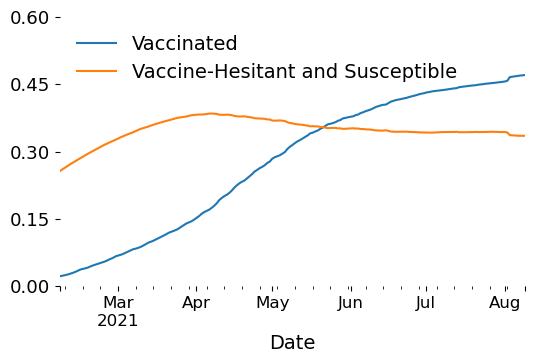

In [15]:
from data_cleaning_tools import interpolate_column

#load MCMC posteriors
def SIRVAD_model(df, null=False): #dummy function to allow me to load the pickle below.
    return
with open("mcmc_res.pickle", "rb") as f:
    posteriors = az.from_numpyro(pickle.load(f))['posterior'] 
    
#get A posteriors means and attach relevant FIPS and dates
A_df = pd.read_parquet('mcmc_res_data_df.parquet')[['date','FIPS']]
A_df['A'] = posteriors['A'].mean(dim=['chain','draw'])
A_df = A_df.sort_values(['FIPS','date']).reset_index(drop=True)

#get susceptibles and missing dates
dates = pd.read_parquet('time_series_df.parquet')[['date','FIPS','population','cumulative_cases','cumulative_vaccinations']]
dates['S'] = (dates['population'] - dates['cumulative_cases'] - dates['cumulative_vaccinations'])/dates['population']
dates['V'] = dates['cumulative_vaccinations'] / dates['population']
dates = dates.drop(columns=['cumulative_cases','cumulative_vaccinations'])

#fill in missing dates
dates = dates[dates['date']>=A_df['date'].min()]
dates = dates[dates['date']<=A_df['date'].max()]
dates = dates[dates['FIPS'].isin(A_df['FIPS'].unique())].sort_values(['FIPS','date'])
A_df = dates.merge(A_df, on=['FIPS','date'], how='left')

#interpolate A to find values on missing dates
A_df = interpolate_column(A_df, 'A')

#get weighted mean over populations
weighted_mean = lambda x: np.average(x, weights=A_df.loc[x.index, 'population'])
A_df = A_df.groupby('date').agg(weighted_mean).drop(columns=['FIPS','population'])

#get S*A
A_df['S*A'] = A_df.eval('S*A')   #note that the A here is equivilent to the alpha in the paper. So A*S here is actually alpha*S=A in the paper. This notational change in the paper was made for clarity, but was not backpropogated into the code.
A_df = A_df[['V', 'S*A']]#, 'A']]

#plot
fig, ax = plt.subplots(figsize=(6, 3.5))
A_df.plot(ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().set_ticks([0.0, 0.15, 0.3, 0.45, 0.6])
# ax.get_legend().remove()
plt.legend(
            ['Vaccinated', 
             'Vaccine-Hesitant and Susceptible',
#             'Fraction of Susceptibles who are Vaccine-Hesitant'
            ],          
            frameon=False, fontsize=14, loc='upper left')
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=12)#, rotation=90)
plt.yticks(fontsize=13)
plt.show()


In [16]:
(A_df['S*A']*337) # estimated total number of vaccine hesitant people, in millions

date
2021-02-06     86.493570
2021-02-07     87.762585
2021-02-08     89.033591
2021-02-09     90.289639
2021-02-10     91.487729
                 ...    
2021-08-05    113.148083
2021-08-06    112.957937
2021-08-07    112.924069
2021-08-08    112.947057
2021-08-09    112.885938
Name: S*A, Length: 185, dtype: float64

# posteriors

In [17]:
import seaborn as sns

In [18]:
def SIRVAD_model(df, null=False): #dummy function to allow me to load the pickle below.
    return
with open("mcmc_res.pickle", "rb") as f:
    mcmc_SIRVAD = pickle.load(f)
idata = az.from_numpyro(mcmc_SIRVAD)

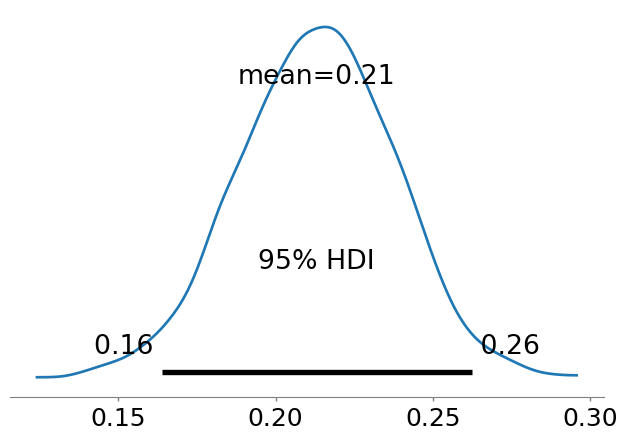

In [19]:
ax = az.plot_posterior(idata, var_names = ['gamma_e'], hdi_prob=0.95, textsize=18)
plt.tight_layout()
plt.title('')
plt.show()

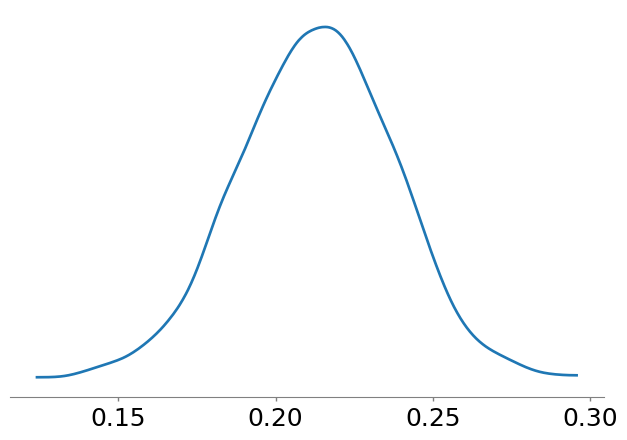

In [20]:
ax = az.plot_posterior(idata, var_names = ['gamma_e'], hdi_prob='hide', point_estimate=None, textsize=18)
plt.tight_layout()
plt.title('')
plt.show()

In [21]:
a = np.array(idata['posterior']['gamma_e']).reshape(-1)
p_gamma_e_leq_zero = (sum(a<=0)+1)/(len(a)+1)
print('p <=', p_gamma_e_leq_zero)

p <= 0.00022217285047767163


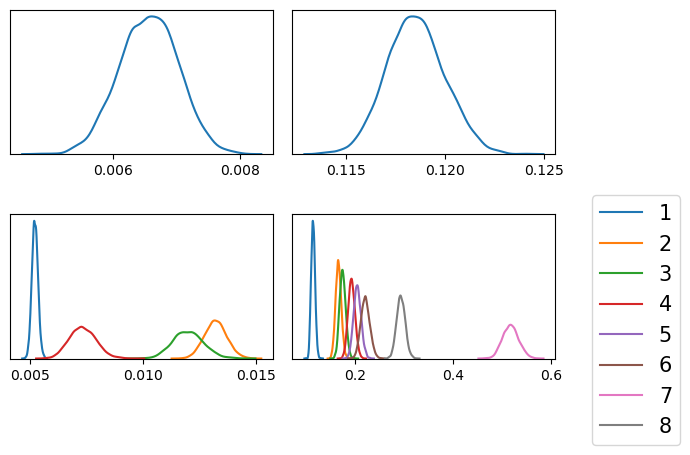

In [22]:
#plot posteriors
variables = ['gamma_p','rho',
             'nu',  'beta',
            ]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 4.5))
plt.rc('xtick', labelsize=15)
for i, v in enumerate(variables):
    ax = axes.ravel()[i]
#     print(v, ax)
    if v+'_dim_0' in dir(idata['posterior'][v]):
        for dim in idata['posterior'][v][v+'_dim_0']:
            posterior = idata['posterior'][v][:,:,dim].to_numpy().ravel()
            sns.kdeplot(posterior, ax=ax)
    else:
        posterior = idata['posterior'][v].to_numpy().ravel()
        sns.kdeplot(posterior, ax=ax)
    
    ax.get_yaxis().set_ticks([])
    ax.set_ylabel('')
    if v=='beta': 
        ax.legend([1,2,3,4,5,6,7,8],bbox_to_anchor=(1.1, 1.2), fontsize=15)
    # if v=='rho':
    #     ax.set_xticks([0.17,0.18,0.19])
        
#     plt.xticks(fontsize=12)#, rotation=90)

plt.tight_layout()



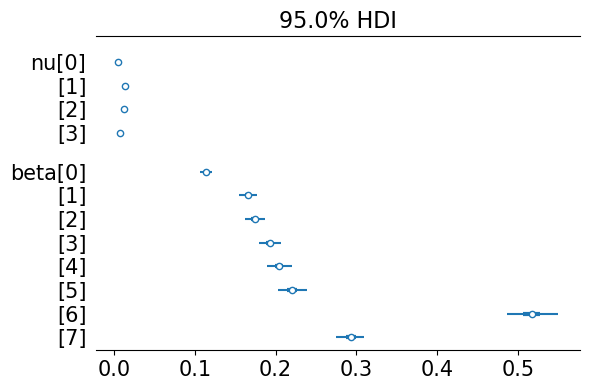

In [23]:
#select variables to plot
var_names=['nu','beta']

#plot trace
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(idata, var_names = var_names, combined = True, hdi_prob=0.95, ax=ax)

plt.tight_layout()
plt.show()

    


In [24]:
# #select variables to plot
# var_names=[
#            'alpha'
#           ]

# #plot trace
# az.plot_trace(idata, var_names = var_names, combined = True)
# plt.tight_layout()
# plt.show()


# check correlates of antivax rate and vaccination

extremely low explained variance. not worth reporting these results. 

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

In [26]:
confounders = ['RepublicanPct2020', 'RUCC_2013', 'Under18Pct2010', 'Age65AndOlderPct2010', 'Ed5CollegePlusPct',
               'GiniCoeff',
               'PopDensity2010_log', 'BlackNonHispanicPct2010_log', 'HispanicPct2010_log', 
               'AsianNonHispanicPct2010_log', 'MedHHInc_log', 'WhiteNonHispanicPct2010_neglog', 
               'n_tweets_all_time_per_capita_log']
confounder_df = pd.read_parquet('time_series_df.parquet').sort_values(by=['date','FIPS'])
confounder_df['V'] = confounder_df['cumulative_vaccinations']/confounder_df['population']
confounder_df['S'] = (confounder_df['population']-confounder_df['cumulative_vaccinations']-confounder_df['cumulative_cases'])/confounder_df['population']
confounder_df = confounder_df[['FIPS','V','S']+confounders].groupby('FIPS').agg('last').reset_index()

df = pd.read_parquet('mcmc_res_data_df.parquet').merge(confounder_df, on='FIPS',how='left')
df = df[['FIPS','V','S']+confounders].groupby('FIPS').agg('last').reset_index().rename(columns={'V':'V_final','S':'S_final'})
df['A_final'] = pd.Series(np.array(idata['posterior']['A'][:,:,-300:].mean(dim=['chain','draw'])))
df['A_0'] = pd.Series(np.array(idata['posterior']['A_0'].mean(dim=['chain','draw'])))
df['A_final*S_final'] = df.eval('A_final*S_final')
df[confounders] = StandardScaler().fit_transform(df[confounders].values)
# df[confounders] = MinMaxScaler().fit_transform(df[confounders].values)


In [27]:
print('raw correlations:')
df[['A_0','A_final','A_final*S_final','V_final']+confounders].corr()[['A_0','A_final','A_final*S_final','V_final']]

raw correlations:


,A_0,A_final,A_final*S_final,V_final
A_0,1.000000,0.063625,0.201155,-0.212537
A_final,0.063625,1.000000,0.165267,0.004992
A_final*S_final,0.201155,0.165267,1.000000,-0.947626
V_final,-0.212537,0.004992,-0.947626,1.000000
RepublicanPct2020,-0.036848,0.051113,0.408559,-0.452207
RUCC_2013,0.031300,0.121787,0.226851,-0.274647
Under18Pct2010,-0.015603,-0.034678,0.145790,-0.116671
Age65AndOlderPct2010,0.031200,0.026145,0.005215,-0.085532
Ed5CollegePlusPct,-0.009469,-0.090964,-0.419905,0.485823
GiniCoeff,0.070400,0.015942,0.008315,-0.042972


In [28]:
def get_random_sample_from_chains(x):
    random_chain = np.random.randint(low=0, high=(x.shape[0]-1))
    random_sample = np.random.randint(low=0, high=(x.shape[1]-1))
    return x[random_chain,random_sample,:]

In [29]:
# #fit regression to samples
# for col in ['A_0','A_final','A_final*S_final','V_final']:
#     print('linear predictors of',col)
#     res = list()
#     explained_variance = list()
#     for i in range(1000):
#         df1 = df.copy()
#         if col=='A_final':
#             df1['A_final'] = pd.Series(get_random_sample_from_chains(np.array(idata['posterior']['A'][:,:,-300:]))) #final antivax rate
#             additional_cols = []
#         elif col=='A_0':
#             df1['A_0'] = pd.Series(get_random_sample_from_chains(np.array(idata['posterior']['A_0']))) #initial antivax rate
#             additional_cols = []
#         elif col=='V_final':
#             additional_cols = ['A_0','A_final']
#         features = confounders+additional_cols
#         X = df1[features].values
#         y = df1[col].values
#         reg = LinearRegression().fit(y=y, X=X)
#         res.append(reg.coef_)
#         explained_variance.append(explained_variance_score(y_true=y, y_pred=reg.predict(X)))

#     #compute mean explained variance
#     explained_variance = pd.Series(explained_variance)
#     explained_variance_lower = explained_variance.quantile(0.025)
#     explained_variance_upper = explained_variance.quantile(0.975)
#     explained_variance_mean = explained_variance.mean()
#     print('explained variance:',explained_variance_mean, '+/-', 
#           max(explained_variance_mean-explained_variance_lower, explained_variance_upper-explained_variance_mean))

#     #clean up regression coefficient results into table
#     res = list(np.array(res).T)
#     res_summary = list()
#     for i,feature_res in enumerate(res):
#         feature_res=pd.Series(feature_res)
#         mean = feature_res.mean()
#         lower = feature_res.quantile(0.025)
#         upper = feature_res.quantile(0.975)
#         if mean>0:  p = ((feature_res<=0).sum()+1)/(feature_res.count()+1) 
#         else: p = ((feature_res>=0).sum()+1)/(feature_res.count()+1)
#         res_summary.append((features[i],"%.3f" % mean,"%.3f" % p,("%.3f" % lower, "%.3f" % upper)))
#     res_summary = pd.DataFrame(res_summary,columns=['feature','coeff','p','95% CI'])
#     res_summary = res_summary.sort_values(['p','coeff'], ascending=[True,False])
#     print(res_summary)
#     print()
#     print()
    

In [30]:
# print(res_summary.to_latex(
#             header = ['Feature','Lin.Reg. Coeff.','p', 'lower','upper'],
#             formatters = {'mean': (lambda x: '{x:.3g}'.format(x=x)),
#                           '95%CI_pm' : (lambda x: '{x:.1g}'.format(x=x)),
#                           'p' : (lambda x: '{x:.2g}'.format(x=x))}    ,
#             index = False,
# ))

# check how many cases/deaths/etc occurred during observation window

In [31]:
df = pd.read_parquet('time_series_df.parquet').sort_values(by=['date','FIPS'])
df = df.groupby('date').agg({'cumulative_vaccinations':'sum',
                             'cumulative_cases':'sum',
                             'cumulative_deaths':'sum',
                             'cumulative_antivax_tweets':'sum',
                             'population':'sum',}).reset_index()
for col in ['cumulative_vaccinations','cumulative_cases','cumulative_deaths','cumulative_antivax_tweets']:
    df[col+'_per_capita'] = df[col]/df['population']

In [32]:
print('population', df['population'].iloc[0])
print('change over observation period from',dates_to_plot.min(), 'to', dates_to_plot.max())
df[df['date']==dates_to_plot.max()].iloc[0] - df[df['date']==dates_to_plot.min()].iloc[0]

population 328700287
change over observation period from 2021-02-06 00:00:00 to 2021-08-09 00:00:00


date                                    184 days 00:00:00
cumulative_vaccinations                       131045595.0
cumulative_cases                                8626355.0
cumulative_deaths                                139333.0
cumulative_antivax_tweets                       1095211.0
population                                              0
cumulative_vaccinations_per_capita               0.398678
cumulative_cases_per_capita                      0.026244
cumulative_deaths_per_capita                     0.000424
cumulative_antivax_tweets_per_capita             0.003332
dtype: object

# estimate case rate and death rate among unvaccinated population and unvaccinatable population





In [33]:
# vaccine_case_prevention_efficacy = 0.58 # https://academic.oup.com/cid/article/75/Supplement_2/S147/6646955
vaccine_case_prevention_efficacy = 0.937 # https://www.nejm.org/doi/full/10.1056/NEJMoa2108891
vaccine_death_prevention_efficacy = 0.94 # https://www.cdc.gov/mmwr/volumes/71/wr/mm7112e1.htm

In [34]:
from data_cleaning_tools import get_dxdts

#get data
df = pd.read_parquet('time_series_df.parquet').sort_values(by=['date','FIPS'])
df = df.groupby('date').agg({'cumulative_vaccinations':'sum',
                             'cumulative_cases':'sum',
                             'cumulative_deaths':'sum',
                             'cumulative_antivax_tweets':'sum',
                             'population':'sum',}).reset_index()

#get A posteriors means and attach relevant FIPS and dates
A_df = pd.read_parquet('mcmc_res_data_df.parquet')[['date','FIPS']]
A_df['A'] = posteriors['A'].mean(dim=['chain','draw'])
A_df = A_df.sort_values(['FIPS','date']).reset_index(drop=True)
dates = pd.read_parquet('time_series_df.parquet')[['date','FIPS','population']]
dates = dates[dates['date']>=A_df['date'].min()]
dates = dates[dates['date']<=A_df['date'].max()]
dates = dates[dates['FIPS'].isin(A_df['FIPS'].unique())].sort_values(['FIPS','date'])
A_df = dates.merge(A_df, on=['FIPS','date'], how='left')
A_df = interpolate_column(A_df, 'A')
pop_weighted_mean = lambda x: np.average(x, weights=A_df.loc[x.index, 'population'])
A_df = A_df.groupby('date').agg({'A':pop_weighted_mean}).reset_index()
df = df.merge(A_df, on=['date'])

#get number of new cases and deaths at each timestep
df['FIPS']=0
df = get_dxdts(df, ['cumulative_cases'])
df = get_dxdts(df, ['cumulative_deaths'])
df = df.drop(columns=['FIPS'])

#compute unvaccinated cases and deaths at each timestep
df = df.rename(columns = {'cumulative_vaccinations':'V',
                          'cumulative_cases':'C',
                          'cumulative_cases_dxdt1':'delta_C',
                          'cumulative_deaths_dxdt1':'delta_D',
                          'population':'N'
                         })
df['S'] = df['N'] - (df['V'] + df['C'])
df['L_c'] = vaccine_case_prevention_efficacy
df['L_d'] = vaccine_death_prevention_efficacy
df['prob_case_given_unvaccinated'] = df.eval('(delta_C/(N-C)) * (((V)/(N-C)) * (1-L_c) + ((N-C-V)/(N-C)))**(-1)')
df['prob_death_given_unvaccinated'] = df.eval('(delta_D/(N-C)) * (((V)/(N-C)) * (1-L_d) + ((N-C-V)/(N-C)))**(-1)')
df['cumulative_cases_dxdt1_unvaccinated'] = df.eval('prob_case_given_unvaccinated * (N-C-V)')
df['cumulative_deaths_dxdt1_unvaccinated'] = df.eval('prob_death_given_unvaccinated * (N-C-V)')
df['cumulative_cases_dxdt1_unvaccinatable'] = df.eval('prob_case_given_unvaccinated * S * A')
df['cumulative_deaths_dxdt1_unvaccinatable'] = df.eval('prob_death_given_unvaccinated * S * A')
df = df.rename(columns = {'V':'cumulative_vaccinations',
                         'delta_C':'cumulative_cases_dxdt1',
                         'delta_D':'cumulative_deaths_dxdt1',
                         'N':'population',
                         'C':'cumulative_cases'
                         })

#compute total unvaccinated cases and deaths
print('total unvaccinated cases during observation window:', round(df['cumulative_cases_dxdt1_unvaccinated'].sum()))
print('total unvaccinated deaths during observation window:', round(df['cumulative_deaths_dxdt1_unvaccinated'].sum()))
print('total unvaccinatable cases:', df['cumulative_cases_dxdt1_unvaccinatable'].sum() )
print('total unvaccinatable deaths:', df['cumulative_deaths_dxdt1_unvaccinatable'].sum())
print('total vaccine-preventable cases:', df['cumulative_cases_dxdt1_unvaccinated'].sum()*vaccine_case_prevention_efficacy)
print('total vaccine-preventable deaths:', df['cumulative_deaths_dxdt1_unvaccinated'].sum()*vaccine_death_prevention_efficacy)
print()

#compute frac of cases and deaths who were unvaccinated
mean_frac_cases_unvaccinated = df['cumulative_cases_dxdt1_unvaccinated'].sum()/df['cumulative_cases_dxdt1'].sum()
mean_frac_deaths_unvaccinated = df['cumulative_deaths_dxdt1_unvaccinated'].sum()/df['cumulative_deaths_dxdt1'].sum()
print('total fraction of cases who were unvaccinated:', mean_frac_cases_unvaccinated)
print('total fraciton of deaths who were unvaccinated:', mean_frac_deaths_unvaccinated)
mean_frac_cases_unvaccinatable = df['cumulative_cases_dxdt1_unvaccinatable'].sum() / df['cumulative_cases_dxdt1_unvaccinated'].sum()
mean_frac_deaths_unvaccinatable = df['cumulative_deaths_dxdt1_unvaccinatable'].sum() / df['cumulative_deaths_dxdt1_unvaccinated'].sum()
print('total fraction of unvaccinated cases who were unvaccinatable:', mean_frac_cases_unvaccinatable)
print('total fraction of unvaccinated deaths who were unvaccinatable:', mean_frac_deaths_unvaccinatable)
print()


#compute total risk of case and death for unvaccinated people
total_prob_case_given_unvaccinated = df['prob_case_given_unvaccinated'].sum()
total_prob_death_given_unvaccinated = df['prob_death_given_unvaccinated'].sum()
print('total prob infection for unvaccinated:', total_prob_case_given_unvaccinated)
print('total prob death for unvaccinated:', total_prob_death_given_unvaccinated)



total unvaccinated cases during observation window: 8327972
total unvaccinated deaths during observation window: 135509
total unvaccinatable cases: 4695077.447719043
total unvaccinatable deaths: 66264.65696200819
total vaccine-preventable cases: 7803310.217484767
total vaccine-preventable deaths: 127378.18016359744

total fraction of cases who were unvaccinated: 0.9764566797895315
total fraciton of deaths who were unvaccinated: 0.9850020520287516
total fraction of unvaccinated cases who were unvaccinatable: 0.5637719693182673
total fraction of unvaccinated deaths who were unvaccinatable: 0.4890066529784572

total prob infection for unvaccinated: 0.038726837887369525
total prob death for unvaccinated: 0.0005689922699465674


In [35]:
n_unvaccinated_as_result_of_antivax_tweets = 753361 #from part 3 of 08causal_graphical_modeling.iypnb. see "cumulative impact on V (# of vaccinations)"

n_cases_among_unvaccinated_subpop = total_prob_case_given_unvaccinated*n_unvaccinated_as_result_of_antivax_tweets
print('n_cases_among_unvaccinated_subpop', n_cases_among_unvaccinated_subpop)
n_deaths_among_unvaccinated_subpop = total_prob_death_given_unvaccinated*n_unvaccinated_as_result_of_antivax_tweets
print('n_deaths_among_unvaccinated_subpop', n_deaths_among_unvaccinated_subpop)
n_cases_attributable_to_antivax_tweets = n_cases_among_unvaccinated_subpop*vaccine_case_prevention_efficacy
print('n cases attributable to antivax tweets', n_cases_attributable_to_antivax_tweets)
n_cases_attributable_to_antivax_tweets = n_deaths_among_unvaccinated_subpop*vaccine_death_prevention_efficacy
print('n deaths attributable to antivax tweets', n_cases_attributable_to_antivax_tweets)


n_cases_among_unvaccinated_subpop 29175.289317666593
n_deaths_among_unvaccinated_subpop 428.656585479216
n_cases_attributable_to_antivax_tweets 27337.2460906536
n_deaths_attributable_to_antivax_tweets 402.937190350463


# inspect correlations between CoVaxxy retweet network and facebook social connectivity index

In [16]:
import pandas as pd

In [39]:
sci = pd.read_csv('../data/social_connectednes_index_facebook.tsv', delimiter='\t')

retweet_network = pd.read_parquet('raw_retweet_neighbor_edgelist.parquet')
retweet_network.rename(columns={'retweeting_FIPS':'user_loc','retweeted_FIPS':'fr_loc'}, inplace=True)
retweet_network.drop(columns=['n_retweets_per_day'], inplace=True)

df = sci.merge(retweet_network, on=['user_loc','fr_loc'], how='left').fillna(0)
print('network correlation:', f'{df[["scaled_sci","n_retweets"]].corr().loc["scaled_sci","n_retweets"]:.4f}')

network correlation: 0.0009


# check linear regression model again

In [45]:
import pandas as pd

#import statsmodels OLS
import statsmodels.api as sm

In [47]:
df = pd.read_parquet('mcmc_res_data_df.parquet')
df['const']=1

y = df['V_dxdt1'].values
X = df[['E_a_dxdt8_tlag1','C_dxdt1','R_dxdt1','D_dxdt1','const']].values

#fit regression with statsmodels OLS, and print summary results
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     586.7
Date:                Sun, 28 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:16:14   Log-Likelihood:                -86209.
No. Observations:                9600   AIC:                         1.724e+05
Df Residuals:                    9595   BIC:                         1.725e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.865e+04   3670.034     -7.808      0.0